## Table of Contents

### 1) import libraries
### 2) load datasets
### 3) delyaed flights vs all flights
### 4) airline carrier delay 
### 5) times and seasonality
### 6) geography and airport size


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import zipfile



#### Load datasets

In [2]:
df_all_flights =pd.read_csv("C:\\Users\sarita\Desktop\MSBA\Q4\MSIS\DelayedFlights\\2008.csv")
df_delayed_flights = pd.read_csv("C:\\Users\sarita\Desktop\MSBA\Q4\MSIS\DelayedFlights\\DelayedFlights.csv")

In [3]:
df_delayed_flights =df_delayed_flights.fillna(0)
df_all_flights = df_all_flights.fillna(0)

#### The delayed flights dataset only contains delayed flights. The all flights data set includes delayed and not delayed flights. Using the count function on each data set, which is grouped by the origin airport, gives the total amount of delayed flights and the total amount of flights for each airport.

In [4]:
df_delayed_flights_by_origin = df_delayed_flights.groupby('Origin').count()
df_all_flights_by_origin = df_all_flights.groupby('Origin').count()

### DELAYED FLIGHTS VS. ALL FLIGHTS

In [5]:
df_all_flights['Delayed']=df_all_flights['DepDelay']>=10

In [8]:
df_all_flights['CRSDate'] = df_all_flights.apply(lambda x: dt.date(x['Year'], x['Month'], x['DayofMonth']), axis=1)

In [9]:
df_flights_by_date = pd.DataFrame(df_all_flights.groupby('CRSDate')['Year'].count())

In [10]:
df_delayed_flights_by_date = pd.DataFrame(df_all_flights[df_all_flights['Delayed']==True].groupby('CRSDate')['Year'].count())

In [11]:
df_flights_by_date['Date']=df_flights_by_date.index
df_delayed_flights_by_date['Date']=df_delayed_flights_by_date.index

In [12]:
df_flights_by_date2=df_flights_by_date.merge(df_delayed_flights_by_date, how='inner', on='Date')

In [13]:
df_flights_by_date2=df_flights_by_date2.rename(columns={'Year_x':'All_Flights', 'Year_y':'Delayed_Flights'})

In [14]:
df_flights_by_date2['Week_Num']=df_flights_by_date2['Date'].apply(lambda x: x.isocalendar()[1])

In [15]:
df_flights_by_week = df_flights_by_date2[['Week_Num', 'All_Flights', 'Delayed_Flights']]

In [16]:
df_flights_by_week2=df_flights_by_week.groupby(['Week_Num']).sum()

In [17]:
df_flights_by_week2['Week_Num']= df_flights_by_week2.index

In [34]:
import matplotlib.ticker as tick
#Format function to show numbers morethan 1000 in the ticks in K
def fmt_x(x,y):
    if x > 1000:
        val = int(x) / 1000
        return '{val:d}K'.format(val=int(val))
    else:
        return int(x)

#### Plot count of all flights and delayed flights by week

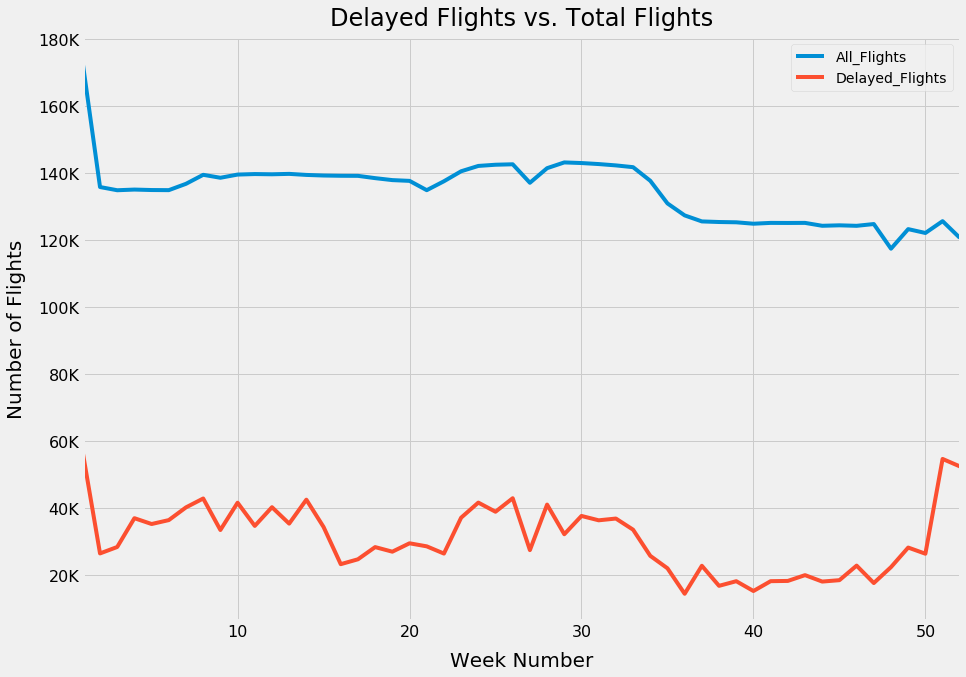

In [40]:
plt.style.use('fivethirtyeight')
ax=df_flights_by_week2.set_index(['Week_Num']).plot(kind='line', figsize=(14, 10), grid=True, fontsize=16)
ax.yaxis.set_major_formatter(tick.FuncFormatter(fmt_x))
plt.title("Delayed Flights vs. Total Flights", fontsize=24, y=1.01)
plt.xlabel("Week Number", fontsize=20, labelpad=12)
plt.ylabel("Number of Flights", fontsize=20, labelpad=12)
plt.show()

ANALYSIS: It is apparent from the graph of all flights and delayed flights that there is a correlation between the two as expected. Surprisingly, the volatility in the delayed curve not present in the all-flights curve indicates that delayed flights is not a perfect function of the total number of flights. For example, the variance (or increases and decreases) in the delayed curve between weeks 10 and 20, 50 and 52 and to a lesser extent 36 and 40, is not reciprocated in the all-flights curve.

## AIRLINE CARRIERS AND DELAYS

In [19]:
df_all_flights=df_all_flights.fillna(0)
df_delayed_flights=df_delayed_flights.fillna(0)

#### Create a df of unique carriers with the corresponding avg carrier delay time

In [20]:
df_all_flights_car=pd.DataFrame(df_delayed_flights.groupby("UniqueCarrier")["CarrierDelay"].mean())

In [21]:
df_all_flights_car["Carrier"]=df_all_flights_car.index

In [22]:
df_airline_codes=pd.read_csv("C:\\Users\sarita\Desktop\MSBA\Q4\MSIS\DelayedFlights\\airline_codes.csv")

#### Merge df_all_flights_car with df_airline_codes to match airline names to carrier codes

In [23]:
df_all_flights_car=pd.merge(df_all_flights_car, df_airline_codes, how='left', left_on="Carrier", right_on="ATA")

In [24]:
df_all_flights_car=df_all_flights_car[["Carrier", "Airline", "CarrierDelay"]]

In [25]:
df_all_flights_car=df_all_flights_car.dropna()
df_all_flights_car=df_all_flights_car[df_all_flights_car.index!=23]

In [26]:
df_all_flights_car=df_all_flights_car.sort_values(by='CarrierDelay')

In [27]:
df_all_flights_car['Average_Carrier_Delay']= df_all_flights_car['CarrierDelay'].mean()

#### Plot bar graph of average carrier-caused delay for each airline

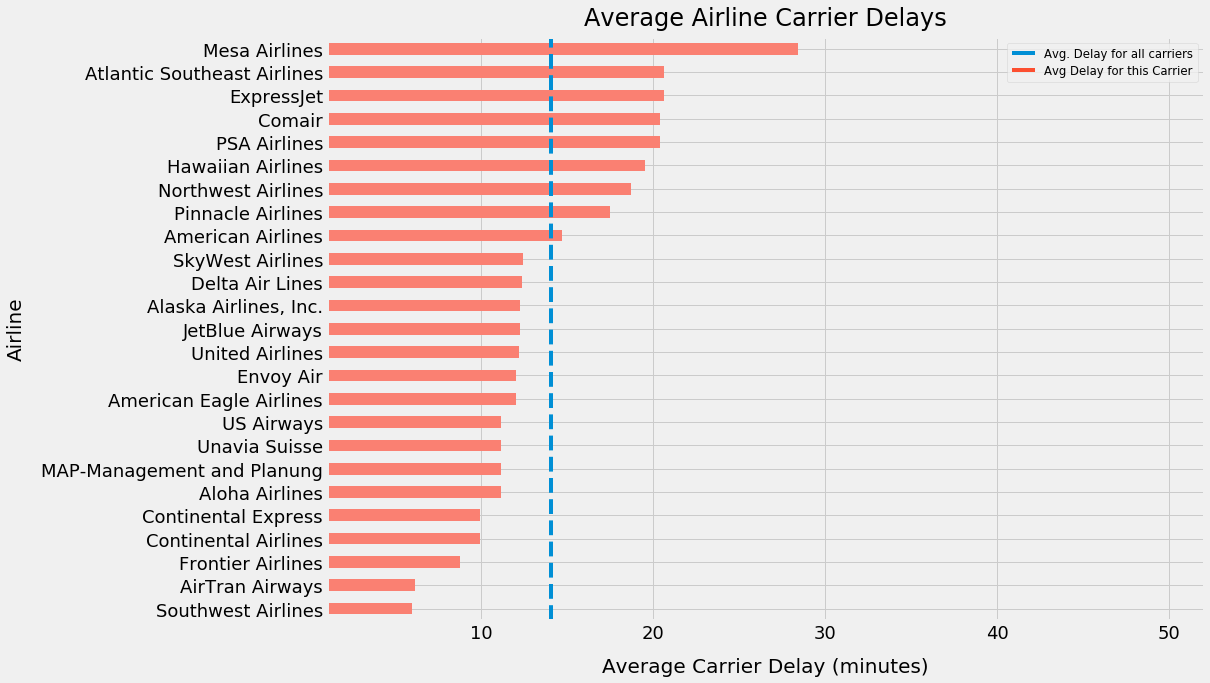

In [28]:
df_all_flights_car.set_index(['Airline'])['CarrierDelay'].plot(kind='barh', figsize=(14, 10), grid=True, fontsize=18, color='salmon')
plt.axvline(df_all_flights_car['Average_Carrier_Delay'].iloc[0], linestyle='--')
plt.title("Average Airline Carrier Delays", fontsize=24, y=1.01)
plt.xlabel("Average Carrier Delay (minutes)", fontsize=20, labelpad=15)
plt.ylabel("Airline", fontsize=20, labelpad=15)
plt.legend(['Avg. Delay for all carriers', 'Avg Delay for this Carrier'], loc=0, fontsize='small');
plt.show()

ANALYSIS:
The major airline carriers, US Airways, United Airlines, and Southwest Airlines appear to have limited carrier-caused 
delay times on average. Conversely, all the carrier who shoulder the blame for the longest extended wait times are 
smaller airlines like Hawaii, Comair, and Atlantic Southeast. Lastly, Mesa Airlines is clearly the worst airline for 
those fliers who lack patience or loose schedules.

#### Create df with percent of flights that are delayed for each carrier

In [37]:
df_car_perc=pd.DataFrame(100*df_delayed_flights.groupby("UniqueCarrier")['Year'].count()/df_all_flights.groupby("UniqueCarrier")['Year'].count())

In [38]:
df_car_perc["Carrier"]=df_car_perc.index

In [39]:
df_car_perc=df_car_perc.rename(columns={'Year':'Percent Delayed'})

#### Join airline name csv to map carrier codes to names

In [40]:
df_car_perc_2=pd.merge(df_car_perc, df_airline_codes, how='left', left_on="Carrier", right_on="ATA")

In [41]:
df_car_perc_2=df_car_perc_2[["Carrier", "Airline", "Percent Delayed"]]

In [42]:
sns.set(font_scale=1.5)

In [43]:
df_car_perc_2=df_car_perc_2[df_car_perc_2.index!=23]
df_car_perc_2=df_car_perc_2.dropna()

In [44]:
df_car_perc_2=df_car_perc_2.sort_values(by='Percent Delayed')

In [45]:
df_car_perc_2['Average_Percent_Delayed']= df_car_perc_2['Percent Delayed'].mean()

#### bar graph of percent delayed for each airline

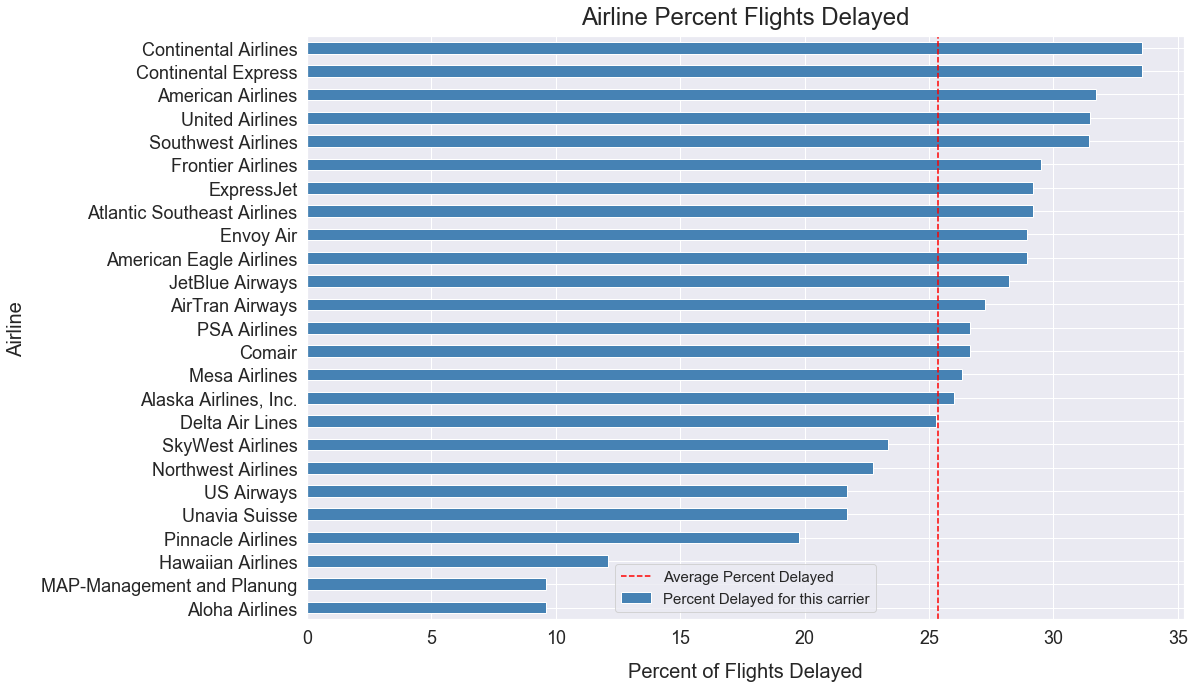

In [50]:
df_car_perc_2.set_index(['Airline'])['Percent Delayed'].plot(kind='barh', figsize=(14, 10), grid=True, fontsize=18, color='steelblue')
plt.axvline(df_car_perc_2['Average_Percent_Delayed'].iloc[0], color='red', linestyle='--')
plt.title("Airline Percent Flights Delayed", fontsize=24, y=1.01)
plt.xlabel("Percent of Flights Delayed", fontsize=20, labelpad=15)
plt.ylabel("Airline", fontsize=20, labelpad=15)
plt.legend(['Average Percent Delayed', 'Percent Delayed for this carrier'], loc=0, fontsize='small');
plt.show()

ANALYSIS: Unlike the average carrier delay times, the major airlines have the highest percentage of flights delayed. 
Interestingly, contrary to their laid-back image, the airlines representing Hawaii boast the most punctual departures
of any carrier.

## TIMES AND SEASONALITY

In [1]:
df_all_flights['CRSDepTime1'] = df_all_flights['CRSDepTime'].apply(lambda x: '{0:0>4}'.format(x))  #pad with 0 to convert to hhmm
df_all_flights['CRSDepTime2'] = df_all_flights['CRSDepTime1'].astype(str)    #convert object to string
df_all_flights.CRSDepTime2 = df_all_flights.CRSDepTime2.str.slice(0, 2)     #Get Hour from CRS Dep time
df_all_flights['CRSDepTimeHr'] = df_all_flights['CRSDepTime2'].astype(int)

NameError: name 'df_all_flights' is not defined

In [41]:
#Create df with percent of flights that are delayed for each day of the week
df_delays_perc = pd.DataFrame(df_all_flights[df_all_flights['Delayed']==True].groupby(['DayOfWeek', 'CRSDepTimeHr'])['Year'].count()*100/df_all_flights.groupby(['DayOfWeek', 'CRSDepTimeHr'])['Year'].count())
df_delays_byhour = df_delays_perc.unstack(level=0)

In [44]:
day_short_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_Hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am','7am','8am','9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

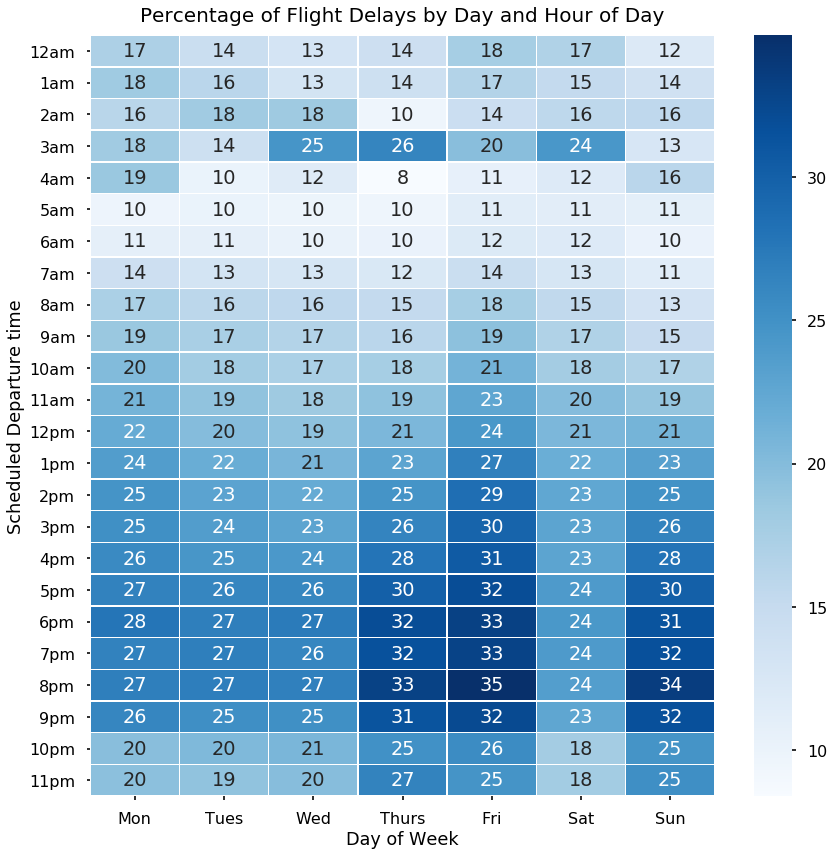

In [45]:
#Create heatmap of the percent of flights delayed for each time of each day of the week
sns.set_context("poster")
f, ax = plt.subplots(figsize=(14, 14))
ax = sns.heatmap(df_delays_byhour, annot=True, fmt="0.0f", linewidths=.5, ax=ax, xticklabels=day_short_names, yticklabels=day_Hours, cmap="Blues")
ax.axes.set_title("Percentage of Flight Delays by Day and Hour of Day", fontsize=20, y=1.01)
ax.set(xlabel='Day of Week', ylabel='Scheduled Departure time');

ANALYSIS: 1. Flights in the afternoon and evening are more delayed than early morning and night on any day of the week. 
          2. Flights delays are maximum on Friday and Sunday evenings at 8 pm.
          3. The percentage of flights delayed at 3am shows higher than normal, but that is a result of bias created by considering percentages instead of the raw numbers. 

In [37]:
df_delays_perc_Month = pd.DataFrame(df_delayed_flights.groupby(['Month', 'DayofMonth'])['Year'].count()*100/df_all_flights.groupby(['Month', 'DayofMonth'])['Year'].count())
df_delays_by_month = df_delays_perc_Month.unstack(level=0)

In [39]:
month_short_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

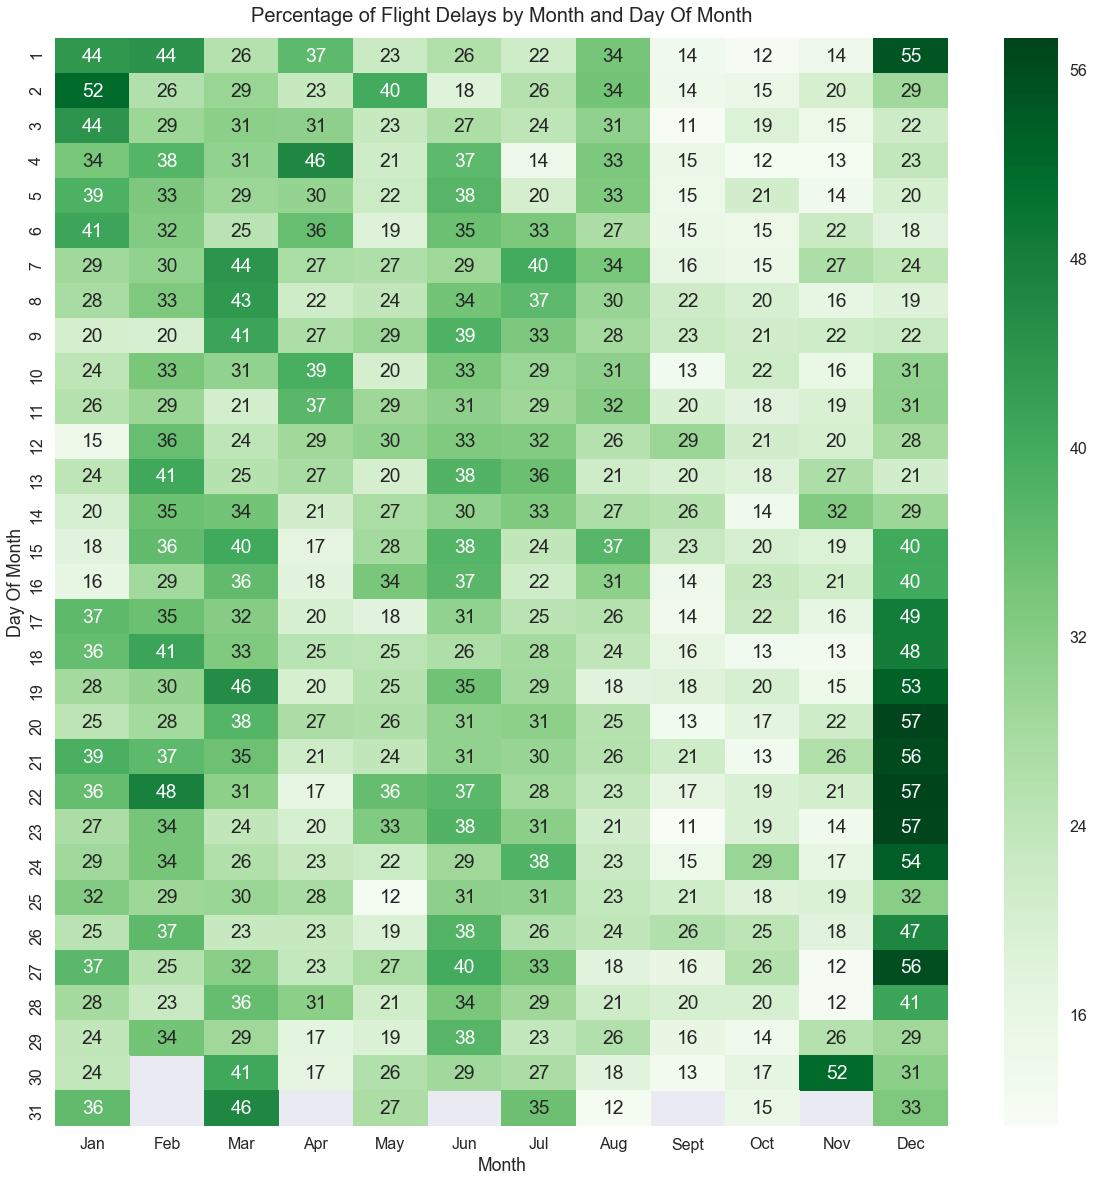

In [40]:
sns.set_context("poster")
f, ax1 = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(dfDelaysByMonth, annot=True, fmt="0.0f", ax=ax1, xticklabels=month_short_names, cmap="Greens")
ax.axes.set_title("Percentage of Flight Delays by Month and Day Of Month", fontsize=20, y=1.01)
ax.set(xlabel='Month', ylabel='Day Of Month');

ANALYSIS: 1. Flight delays are maximum in the around holiday season .
           2. During Christmas and Thanksgiving, the delays could go up to 57%
           3. We have some outliers in the middle of February and end of March, where there are no holidays or any reason that stands out.

### GEOGRAPHY AND AIRPORT SIZE

#### clean airport location data set

In [5]:
df_airport_location.columns = ['AirportID',
               'Name',
               'City',
               'Country',
               'IATA',
               'ICAO',
               'Lat',
               'Lon',
               'Alt',
               'TimeZone',
               'DST',
               'time',
               'zone',
               'type',
                ]

In [6]:
df_airport_location.drop(['AirportID'],axis=1,inplace=True)
df_airport_location.drop(['Name'],axis=1,inplace=True)
df_airport_location.drop(['Country'],axis=1,inplace=True)
df_airport_location.drop(['ICAO'],axis=1,inplace=True)
df_airport_location.drop(['Alt'],axis=1,inplace=True)
df_airport_location.drop(['TimeZone'],axis=1,inplace=True)
df_airport_location.drop(['DST'],axis=1,inplace=True)
df_airport_location.drop(['time'],axis=1,inplace=True)
df_airport_location.drop(['zone'],axis=1,inplace=True)
df_airport_location.drop(['type'],axis=1,inplace=True)
df_airport_location['city'] = df_airport_location['City'] # create City as last column of dataframe
df_airport_location.drop(['City'],axis=1,inplace=True)# drop city since it is added as the last column of the dataframe

In [7]:
# rename columns 
df_airport_location.columns = ['Airport',
              'Lat',
              'Lon',
              'City']

In [8]:
# make a list of all the unique airports that had flight delays  
Airports = df_delayed_flights['Origin'].unique()
Airports.sort()

#### Add total flights and name of airport columns to the delayed flights data set

In [9]:
# add a column to delayed flights data set with the total number of flights from 
# each airport. Add a column with the names of all the airport 

df_delayed_flights_by_origin['TotalFlights'] = df_all_flights_by_origin['LateAircraftDelay']
df_delayed_flights_by_origin['Airport'] = Airports

In [10]:
# calculate percentage of delayed flights from each airport
df_delayed_flights_by_origin['PercentofDelayedFlights'] = round(((df_delayed_flights_by_origin['LateAircraftDelay']/df_delayed_flights_by_origin['TotalFlights'])*100),2)

In [11]:
df_delayed_flights_by_origin.drop(df_delayed_flights_by_origin.iloc[:, 0:28], inplace=True, axis=1)

#### Merge the airport longitude and latitude data to the delayed flights data set

In [12]:
df_merge_airport_location_delayed_flights= pd.merge( df_airport_location, df_delayed_flights_by_origin, on = 'Airport', how = 'right')
df_merge_airport_location_delayed_flights = df_merge_airport_location_delayed_flights.sort_values(by=['LateAircraftDelay'], ascending = False)

## Plot Bubble Map

df_merge_airport_location_delayed_flights is sorted from most amount of delays to least
delays. The limits variable below is used to separate the two airports with the highest amount of delays (in blue on the map) from the rest of the airports (in orange). The size of each bubble is determined by the number of delays from each airport.

In [13]:
df_merge_airport_location_delayed_flights['text'] = df_merge_airport_location_delayed_flights['Airport'] + ': ' + df_merge_airport_location_delayed_flights['City'] + ' <br>Number Of Delays: ' + (df_merge_airport_location_delayed_flights['LateAircraftDelay']).astype(str) + '<br>' + (df_merge_airport_location_delayed_flights['PercentofDelayedFlights']).astype(str) + '% of flights delayed'
limits = [(0,2), (3,302)]
colors = ["rgb(255,65,54)","rgb(0,116,217)"]
names = ['Greater than 125,000 delays', 'Less than 125,000 delays']
airports = []
scale = 50

for i in range(len(limits)):
    lim = limits[i]
    df_sub1 = df_merge_airport_location_delayed_flights[lim[0]:lim[1]]
    airport = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub1['Lon'],
        lat = df_sub1['Lat'],
        text = df_sub1['text'],
        marker = dict(
            size = df_sub1['LateAircraftDelay']/scale,        
            colors = colors [i],
            line = dict(width=1, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i])
    airports.append(airport)

layout = dict(
        title = 'Amount of Delays per US Airport in 2008<br>(Click Legend to Toggle Traces)',
        showlegend = (True),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)",
    ),
)
fig2 = dict( data=airports, layout=layout )
py.iplot(fig2, validate=False, filename='d3-bubble-map-populations')
#py.offline.iplot( fig2, validate=False, filename='d3-bubble-map-populations' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~skenny/0 or inside your plot.ly account where it is named 'd3-bubble-map-populations'


### Bubble Map Insights:
    
Each bubble represents an airport and the size of the bubbles indicate the amount of the 
delays relative to the other airports. The airports with most amount of delays are ATL 
in Atlanta and ORD in Chicago.

ATL had 131,613 delays which constitutes 31.75% of all flights from ATL.
ORD had 125,979 delays which constitutes 35.95% of all flights from ORD.

Some airports with a lower amount of delays had a higher percentage of delayed flights.
For example, AKN in King Salmon had 72 delays which constitutes 62.07% of all flights from AKN.